# Real NVP

One challenge of flow-based models is to find a transformation $f$ that is invertible, has a simple Jacobian determinant, and possesses sufficient expressive power. In 2014, Dinh et al. proposed a clever way of constructing such transformations using coupling layers. Their approach, known as NICE (Non-linear Independent Components Estimation), involves splitting the input data into two parts and applying an affine transformation to one part conditioned on the other. Formally, let $\mathbf{x}\in \mathbb{R}^D$ denote the input sequence, the function $\mathbf{z}=f(\mathbf{x})$ acts as follows

$$\begin{equation*}
\begin{cases}
\mathbf{z}_{1:D/2} = \mathbf{x}_{1:D/2}\\
\mathbf{z}_{D/2:D} = \mathbf{x}_{D/2:D} + m_{\theta}(\mathbf{x}_{1:D/2})\\
\end{cases}
\end{equation*}$$

Note that $f$ is invertible, with inverse being

$$\begin{equation*}
\begin{cases}
\mathbf{x}_{1:D/2} = \mathbf{z}_{1:D/2} \\
\mathbf{x}_{D/2:D} = \mathbf{z}_{D/2:D} - m_{\theta}(\mathbf{z}_{1:D/2})\\
\end{cases}
\end{equation*}$$

Moreover, evaluating the inverse does not involve taking the inverse of $m_\theta$. This means that we can parameterize $m_{\theta}$ however we want! (for example, with a neural network). The Jacobian of the map is also easy to compute

$$\frac{\partial \mathbf{z}}{\partial \mathbf{x}} = \begin{bmatrix}
1 & 0\\
\frac{\partial m_{\theta}}{\partial \mathbf{z}} & 1
\end{bmatrix} \implies \bigg|\frac{\partial \mathbf{z}}{\partial \mathbf{x}}\bigg|=1$$

One downside of such a mapping is that it only modifies half of $\mathbf{x}$. To modify all of $\mathbf{x}$, we can consider stacking multiple layers of the mapping $f$ with alternating partitions of $\mathbf{x}$ (Figure 1). This allows the entire input to be modified and enhances the overall expressiveness of the model. <br>


Two years later, Dinh et al. proposed RealNVP, which serves as a generalization of the NICE architecture. The flow function in RealNVP takes a similar form to that in NICE.

$$\begin{equation*}
\begin{cases}
\mathbf{z}_{1:D/2} = \mathbf{x}_{1:D/2}\\
\mathbf{z}_{D/2:D} = \mathbf{x}_{D/2:D} \odot \exp(s(\mathbf{x}_{1:D/2}))+ t(\mathbf{x}_{1:D/2})\\
\end{cases}
\end{equation*}$$

Whose inverse is given by 

$$\begin{equation*}
\begin{cases}
\mathbf{x}_{1:D/2} = \mathbf{z}_{1:D/2}\\
\mathbf{x}_{D/2:D} = (\mathbf{z}_{D/2:D} - t(\mathbf{z}_{1:D/2}))\odot \exp(-s(\mathbf{z}_{1:D/2}))\\
\end{cases}
\end{equation*}$$

As before, computing the inverse does not require taking the inverse of $s$ or $t$, meaning we can parameterize $s$ and $t$ as deeply as we want. The Jacobian of the flow is given by

$$\frac{\partial \mathbf{z}}{\partial \mathbf{x}} = \begin{bmatrix}
1 & 0\\
\frac{\partial \mathbf{z}_{D/2:D}}{\partial \mathbf{x}_{1:D/2}} & \exp(s(\mathbf{x}_{1:D/2}))
\end{bmatrix} \implies \bigg|\frac{\partial \mathbf{z}}{\partial \mathbf{x}}\bigg|=\exp(s(\mathbf{x}_{1:D/2}))$$

This Jacobian can be computed during the forward pass! However, the flow proposed in RealNVP suffers from the same problem as the one in NICE—both only modify half of the input sequence. To overcome this, Dinh et al. proposed stacking these layers with different patterns. Below, we discuss the architecture of RealNVP.

## RealNVP architecture

### Masking scheme

The triangular computational graph of RealNVP can be implemented using a binary mask. The mapping $f$ can be concisely expressed as

$$\mathbf{z} = b\odot \mathbf{x} + (1-b) \odot \bigg(\mathbf{x} \odot \exp(s(b \odot \mathbf{x})) + t(b \odot \mathbf{x})\bigg)$$

With inverse being

$$\mathbf{x} = b\odot \mathbf{z} + (1-b) \odot \bigg((\mathbf{z} - t(b \odot \mathbf{z})) \odot \exp(-s(b \odot \mathbf{z}))\bigg)$$

One advantage of using this notation is that we can apply any binary mask we like, rather than simply flattening and splitting the sequence in half.  In the paper, Dinh et al. applied two types of masks: checkerboard masks and channel masks (Figure 2). <br>


Each layer uses one of the masks and produces output based on equation $(1)$. The functions $s$ and $t$ are parameterized following a ResNet architecture, with standard convolution replaced by weighted convolution. For the scale function $s$, a $\tanh$ activation is applied at the end to constrain the value to $[-1, 1]$. The constrained value is then multiplied by a learnable scale parameter.

### RealNVP Block

A RealNVP block is composed of three alternating checkerboard masks, followed by a squeeze operation, and then three alternating channel masks. The squeeze operation reduces a tensor of shape $[C, H, W]$ to $[4C, \frac{H}{2}, \frac{W}{2}]$. This trades spatial dimensions for the number of channels. In the final layer, the block is replaced by four alternating checkerboard masks. 

### Multiscale architecture

To save computational and memory costs, Dinh et al. factored out half of the variables after each RealNVP block. The factored variable is flattened and concatenated with other factored variables. This operation is defined recursively as:

$$
\begin{align*}
    \mathbf{h}^{(0)} &= \mathbf{x}\\
    (\mathbf{z}^{(i+1)}, \mathbf{h}^{(i+1)}) &= f^{(i+1)}(\mathbf{h}^{(i)})\\
    \mathbf{z}^{(L)} &= f^{(L)}(\mathbf{h}^{(L-1)})\\
    \mathbf{z} &= (\mathbf{z}^{(1)}, \mathbf{z}^{(2)},..., \mathbf{z}^{(L)})
\end{align*}
$$

The final vector $\mathbf{z}$ is then modeled as a multivariate Gaussian. 

### Loss function

To train the RealNVP, we need a loss function. Let $f_a, f_b$ be two coupling layers, stacking them gives us the Jacobian:

$$\frac{\partial f_b\circ f_a}{\partial \mathbf{x}_a^T}(\mathbf{x}_a) = \frac{\partial f_a}{\partial \mathbf{x}_a^T}(\mathbf{x}_a) \frac{\partial f_b}{\partial \mathbf{x}_b^T}(\mathbf{x}_b=f_a(\mathbf{x}_a))$$

Taking determinants on both sides gives us:

$$
\begin{align*}
\bigg|\frac{\partial f_b\circ f_a}{\partial \mathbf{x}_a^T}(\mathbf{x}_a)\bigg| &= \bigg|\frac{\partial f_a}{\partial \mathbf{x}_a^T}(\mathbf{x}_a)\bigg|\cdot \bigg|\frac{\partial f_b}{\partial \mathbf{x}_b^T}(\mathbf{x}_b=f_a(\mathbf{x}_a))\bigg|\\
&= \exp(s_a(\mathbf{x}_{1:d/2}))\cdot \exp(s_b(\mathbf{x}_{1:d/2}))\\
&= \exp(s_a(\mathbf{x}_{1:d/2}) + s_b(\mathbf{x}_{1:d/2}))
\end{align*}
$$

This implies that the Jacobian of the stacked layers is essentially the exponential of the summed scale outputs. Therefore, the log-likelihood can be written as:

$$
\begin{align*}
\log p_{\mathbf{x}}(x) &= \log p_{\mathbf{z}}(z) + \log\bigg|\frac{\partial f}{\partial x}\bigg|\\
&= \log p_{\mathbf{z}}(z) + \log \exp\bigg(-\sum_i s_i(\mathbf{x}_{1:d})\bigg)\\
&= -\frac{1}{2}\log(2\pi) -\frac{(f(\mathbf{x}))^2}{2} + \sum_i s_i(\mathbf{x}_{1:d})\\
\end{align*}
$$

Each of these components can be computed efficiently during the forward pass.

## Implementation

Below we implement a RealNVP and train the model on MNIST and CIFAR10 datasets. We focus on implementing the coupling layer and the RealNVP block. 

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.distributions import MultivariateNormal
import torch.nn.functional as F
from RealNVP import *

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root="data", train=True, transform=transform, download=True)
mnist_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root="data", train=True, transform=transform, download=True)
cidar_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Coupling layer implementation

We first implement the checkerboard and channel binary masks. The `requires_grad` is set to `False` as the binary mask is not learnable. In the implementation of the Coupling layer, we use a single ResNet to generate the scale $s $ and translation $t$ parameters. The `reverse` parameter, when set to `True`, reverses the binary mask from `b` to `1-b`. This ensures that all pixels are processed during the forward pass.

In [ ]:
def getCheckboardMask(C, H, W, device="cpu"):
    mask = torch.zeros(C, H, W, requires_grad=False, device=device)
    for i in range(H):
        for j in range(W):
            if (i + j) % 2 == 0:
                mask[:, 2*i:2*(i+1), 2*j:2*(j+1)] = 1
    return mask

def getChannelMask(C, H, W, device="cpu"):
    assert C % 2 == 0, "Need even number of channels"
    mask = torch.cat([torch.ones(C // 2, H, W, device=device), torch.zeros(C // 2, H, W, device=device)], dim=0)
    mask.requires_grad = False
    return mask

class CouplingLayer(nn.Module):
    def __init__(self, in_channels, hidden_channels, height, width, n_layers, mask_type, reverse, device="cpu"):
        super(CouplingLayer, self).__init__()
        self.st_resnet = Resnet(in_channels, hidden_channels, 2*in_channels, n_layers)
        self.scale = nn.Parameter(torch.ones(1, in_channels, 1, 1))
        if mask_type == "CHECKERBOARD":
            self.mask = getCheckboardMask(in_channels, height, width, device=device)
        elif mask_type == "CHANNEL":
            self.mask = getChannelMask(in_channels, height, width, device=device)
        else:
            raise ValueError("Invalid mask type!")
        if reverse:
            self.mask = 1 - self.mask

    def forward(self, x, s_det):
        st = self.st_resnet(x * self.mask)
        s, t = torch.chunk(st, 2, dim=1)
        s = self.scale * torch.tanh(s)
        x = self.mask * x + (1 - self.mask) * (x * s.exp() + t)
        s_det += (s * (1-self.mask)).view(x.shape[0], -1).sum(axis=-1)
        return x, s_det

    def inverse(self, z):
        st = self.st_resnet(z * self.mask)
        s, t = torch.chunk(st, 2, dim=1)
        s = self.scale * torch.tanh(s)
        x = self.mask * z + (1-self.mask) * (z - t) / s.exp()
        return x

### RealNVP Implementation

Moving on the the implementation of the RealNVP block, which essentially follows the structure of Figure 2. 

In [ ]:
class RealNVPBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels, height, width, n_layers, last_block=False, device="cpu"):
        super(RealNVPBlock, self).__init__()
        self.last_block = last_block
        self.in_coupling = nn.ModuleList([
            CouplingLayer(in_channels, hidden_channels, height, width, n_layers, mask_type="CHECKERBOARD", reverse=False, device=device),
            CouplingLayer(in_channels, hidden_channels, height, width, n_layers, mask_type="CHECKERBOARD", reverse=True, device=device),
            CouplingLayer(in_channels, hidden_channels, height, width, n_layers, mask_type="CHECKERBOARD", reverse=False, device=device)
        ])
        if last_block:
            self.out_coupling = nn.ModuleList([
                CouplingLayer(in_channels, hidden_channels, height, width, n_layers, mask_type="CHECKERBOARD", reverse=True, device=device)])
        else:
            self.out_coupling = nn.ModuleList([
                CouplingLayer(4*in_channels, hidden_channels, height//2, width//2, n_layers, mask_type="CHANNEL", reverse=False, device=device),
                CouplingLayer(4*in_channels, hidden_channels, height//2, width//2, n_layers, mask_type="CHANNEL", reverse=True, device=device),
                CouplingLayer(4*in_channels, hidden_channels, height//2, width//2, n_layers, mask_type="CHANNEL", reverse=False, device=device),
            ])

    def forward(self, x, s_det):
        for coupling in self.in_coupling:
            x, s_det = coupling(x, s_det)
        if not self.last_block:
            x = self.squeeze(x)
        for coupling in self.out_coupling:
            x, s_det = coupling(x, s_det)
        return x, s_det

    def squeeze(self, x):
        B, C, H, W = x.shape
        x = x.view(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
        x = x.view(B, C * 2 * 2, H // 2, W // 2)
        return x

    def inverse(self, z):
        for coupling in reversed(self.out_coupling):
            z = coupling.inverse(z)
        if not self.last_block:
            z = self.unsqueeze(z)
        for coupling in reversed(self.in_coupling):
            z = coupling.inverse(z)
        return z

    def unsqueeze(self, x):
        B, C, H, W = x.shape
        x = x.view(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
        x = x.view(B, C // 4, H * 2, W * 2)
        return x

### RealNVP implementation

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, in_channels, hidden_channels, height, width, n_layers, n_scales, device="cpu"):
        super(RealNVP, self).__init__()
        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.net = [RealNVPBlock(2**i*in_channels, hidden_channels, height//(2**i), width//(2**i), n_layers, device=device) for i in range(n_scales-1)]
        self.net += [RealNVPBlock(2**(n_scales-1)*in_channels, hidden_channels, height//(2**(n_scales-1)), width//(2**(n_scales-1)), n_layers, last_block=True, device=device)]
        self.net = nn.ModuleList(self.net)
        self.device = device

    def forward(self, x):
        x, s_det = self.quantize(x)
        z_list = []
        for block in self.net:
            x, s_det = block(x, s_det)
            if not block.last_block:
                x, z = torch.chunk(x, 2, dim=1)
            else:
                z = x
            z_list.append(z.view(z.shape[0], -1))
        z = torch.cat(z_list, dim=1)
        return z, s_det

    def sample(self, n_samples):
        idx, n = 0, len(self.net)
        vol = self.in_channels * self.height * self.width
        z = MultivariateNormal(torch.zeros(vol), torch.eye(vol)).sample((n_samples,))
        z = z.to(self.device)
        z = torch.flip(z, dims=[1])
        for block in reversed(self.net):
            if n == len(self.net):
                z_in = z[:, idx: idx+vol//(2**(n-1))]
                z_in = z_in.reshape(z_in.shape[0], 2**(n-1)*self.in_channels, self.height//(2**(n-1)), self.width//(2**(n-1)))
                x = block.inverse(z_in)
                idx += vol//(2**(n-1))
            else:
                z_in = z[:, idx: idx+vol//(2**n)]
                z_in = z_in.reshape(z_in.shape[0], 2**n*self.in_channels, self.height//2**n, self.width//2**n)
                z_in = torch.cat([x, z_in], dim=1)
                x = block.inverse(z_in)
                idx += vol//(2**n)
            n -= 1

        return x

    def quantize(self, x, alpha=torch.tensor([0.9], requires_grad=False, device="cpu")):
        alpha = alpha.to(self.device)
        y = (x * 255. + torch.rand_like(x, device=self.device)) / 256.
        y = (2 * y - 1) * alpha
        y = (y + 1) / 2
        y = y.log() - (1. - y).log()
        ldj = F.softplus(y) + F.softplus(-y) \
            - F.softplus((1. - alpha).log() - alpha.log())
        sldj = ldj.view(ldj.size(0), -1).sum(-1)
        return y, sldj

### Loss function

The loss function follows equation $(1)$. It is composed of the negative log-likelihood loss of the Multivariate Gaussian, and the Jacobian component. 

In [ ]:
def loss_fn(z, s_det):
    nll = (0.5 * z ** 2).sum(-1) + 512 * np.log(2 * np.pi)
    loss = nll - s_det
    return loss.mean()

## On MNIST

After implementing RealNVP, we tested its performance on the MNIST dataset. For the scale and translation parameters, we used $8$ layers of ResNet blocks with $64$ hidden channels. Three RealNVP blocks were stacked on top of each other. We trained the model for $30$ epochs with a learning rate of $10^{-3}$ using the Adam optimizer. <br>

The resulting generated image is shown below. As we can see, the model is capable of generating realistic MNIST images, although some samples exhibit discontinuities. We stopped the training early, so additional training would likely improve the results.

In [ ]:
realnvp = RealNVP(in_channels=1, hidden_channels=64, height=32, width=32, n_layers=8, n_scales=3, device=DEVICE)
realnvp = realnvp.to(DEVICE)
optimizer = optim.Adam(realnvp.parameters(), lr=1e-3)
train(realnvp, optimizer, mnist_train_loader, n_epochs=30, device=DEVICE, sample=True)

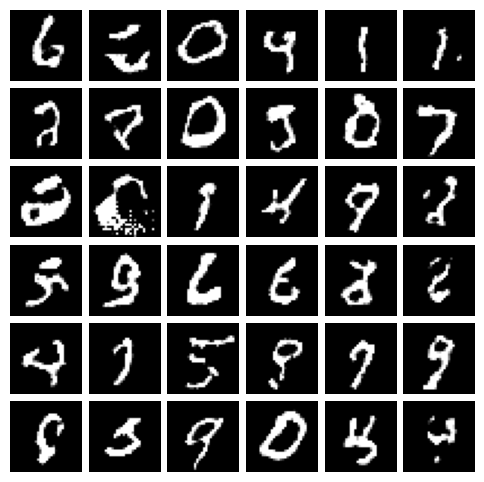

In [ ]:
plot_samples(realnvp, 36, device=DEVICE)

## On CIFAR10

We then applied the same architecture and hyperparameter settings to the CIFAR10 dataset. The model was able to generate diverse images that resemble those in the CIFAR10 dataset.

In [ ]:
realnvp = RealNVP(in_channels=3, hidden_channels=64, height=32, width=32, n_layers=8, n_scales=3, device=DEVICE)
realnvp = realnvp.to(DEVICE)
optimizer = optim.Adam(realnvp.parameters(), lr=1e-3)
train(realnvp, optimizer, cifar_train_loader, n_epochs=30, device=DEVICE, sample=True)

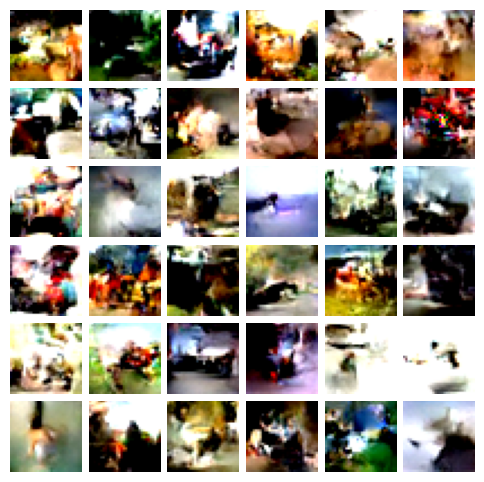

In [ ]:
plot_samples(realnvp, 36, device=DEVICE)